In [1]:
using Gen
using Flux
using JLD
using Random
using StatsBase
using LinearAlgebra
using PyPlot
using Distributions

push!(LOAD_PATH, "/home/jberez/Projects/BostonHousing/docker-parallel2")

include("docker-parallel2/LoadData.jl")
include("docker-parallel2/NUTS.jl")
include("docker-parallel2/proposals.jl")
include("docker-parallel2/utils.jl")
#include("hmc_mod.jl");

In [2]:
#Load Boston Housing Data

dx, dy, x_train, x_test, y_train, y_test = load_data(10);

UndefVarError: UndefVarError: load_data not defined

In [3]:
x_train

13×253 Transpose{Float64,Array{Float64,2}}:
 -0.151092   -0.351504  -0.272052   …  -0.405478   -0.152661   -0.410371
 -0.48724    -0.48724   -0.48724        1.44223    -0.48724     1.44223
  1.23073     1.56744    1.23073       -1.12192     1.23073    -1.12192
 -0.272329   -0.272329   3.66477       -0.272329   -0.272329   -0.272329
  0.434121    0.598087   0.434121      -1.01568     0.434121   -1.01568
 -0.575896    0.124343  -0.0492934  …   0.386221    0.0489109   1.28145
  1.02047     1.04179    0.853502      -1.40236     0.977841   -1.05421
 -0.667871   -0.696982  -0.948204       0.366459   -0.804974    0.366459
 -0.522484   -0.637331  -0.522484      -0.522484   -0.522484   -0.522484
 -0.0310742   0.170662  -0.0310742     -0.0607412  -0.0310742  -0.0607412
 -1.7347      1.26768   -1.7347     …  -1.50375    -1.7347     -1.50375
 -0.0935872   0.318594  -0.194469       0.286609   -0.652655    0.440616
 -0.0872508  -0.214683  -1.00168       -1.13331    -0.217484   -1.01708

In [21]:
#Network hyperparameters
k_real = 8 #Number of hidden nodes per layer
k_vector = [0.0 for i=1:k_real]
k_vector[k_real] = 1.0

#Layer hyperparameters
l_range = 4 #Maximum number of layers in the network
l_list = [Int(i) for i in 1:l_range]
l_real = 1;

#Hyperprior Hyperparameters
αᵧ = 1 #Regression Noise Shape
βᵧ = 1 #Regression Noise Scale/Rate
α₁ = 1 #Input Weights, Biases Shape
β₁ = 1 #Input Weights, Biases Scale/Rate
α₂ = 1 #Hidden & Output Weights Shape
β₂ = k_real; #Hidden & Output Weights Scale

In [9]:
#Bayesian Neural Network 

function G(x, trace)
    activation = tanh
    l = trace[:l]
    ks = [trace[(:k,i)] for i=1:l]
    
    for i=1:l
        in_dim, out_dim = layer_unpacker(i, l, ks)
        W = reshape(trace[(:W,i)], out_dim, in_dim)
        b = reshape(trace[(:b,i)], trace[(:k,i)])
        nn = Dense(W, b, activation)
        x = nn(x)
    end
    
    Wₒ = reshape(trace[(:W,l+1)], 1, ks[l])
    bₒ = reshape(trace[(:b,l+1)], 1)
    
    nn_out = Dense(Wₒ, bₒ)
    return nn_out(x)
    
end;

In [22]:
#Probabilistic Model

@gen function interpolator(x)
    
    d = length(x[:,1])
    
    #Create a blank choicemap
    obs = choicemap()::ChoiceMap
    
    #Draw number of layers
    l ~ categorical([1/length(l_list) for i=1:length(l_list)])
    l_real = l
    obs[:l] = l
    
    #Create individual weight and bias vectors
    #Loop through hidden layers
    k = [Int(0) for i=1:l+1]
    for i=1:l
        k[i] = @trace(categorical(k_vector), (:k,i))
        obs[(:k,i)] = k[i]
    end
    k[l+1] = @trace(categorical([1.0]), (:k,l+1))
    obs[(:k,l+1)] = k[l+1]
    
    #####################################
    #New hyperparameter schedule - Mar 8#
    #####################################
    
    τ = [0.0 for i=1:l+1]
    τᵦ = [0.0 for i=1:l+1]
    σ = [0.0 for i=1:l+1]
    σᵦ = [0.0 for i=1:l+1]
    
    for i=1:l+1
        if i==1
            τ[i] = @trace(gamma(α₁,β₁), (:τ,i))
            τᵦ[i] = @trace(gamma(α₁,β₁), (:τᵦ,i))
        else
            τ[i] = @trace(gamma(α₂,β₂), (:τ,i))
            τᵦ[i] = @trace(gamma(α₁,β₁), (:τᵦ,i))
        end
        σ[i] = 1/τ[i]
        σᵦ[i] = 1/τᵦ[i]
    end
    
    #Noise Variance
    τᵧ ~ gamma(αᵧ,βᵧ)
    σᵧ = 1/τᵧ
    
    #Sample weight and bias vectors
    W = [zeros(k[i]) for i=1:l+1]
    b = [zeros(k[i]) for i=1:l+1]

    for i=1:l+1
        if i == 1
            h = Int(d * k[i])
        else
            h = Int(k[i-1] * k[i])
        end

        if i<=l
            #Hidden Weights
            u = zeros(h)
            S = Diagonal([σ[i] for j=1:length(u)])::Diagonal{<:Real}
            W[i] = @trace(mvnormal(u,S), (:W,i))
            obs[(:W,i)] = W[i]
            
            #Hidden Biases
            ub = zeros(k[i])
            Sb = Diagonal([σᵦ[i] for j=1:length(ub)])::Diagonal{<:Real}    
            b[i] = @trace(mvnormal(ub,Sb), (:b,i))
            obs[(:b,i)] = b[i]
        else
            #Output Weights
            u = zeros(k[l])
            S = Diagonal([σ[i] for j=1:length(u)])::Diagonal{<:Real}
            W[i] = @trace(mvnormal(u,S), (:W,i))
            obs[(:W,i)] = W[i]

            #Output Bias
            ub = zeros(1)
            Sb = Diagonal([σᵦ[i] for j=1:length(ub)])::Diagonal{<:Real}  
            b[i] = @trace(mvnormal(ub,Sb), (:b,i))
            obs[(:b,i)] = b[i]
        end
    end
    
    #Return Network Scores for X
    scores = transpose(G(x,obs))[:,1]
    
    #Regression Likelihood
    Sy = Diagonal([σᵧ for i=1:length(x[1,:])])::Diagonal{<:Real}
    y = @trace(mvnormal(vec(scores), Sy), (:y))

    return scores
    
end

obs_master = choicemap()::ChoiceMap
obs_master[:y] = y_train
obs = obs_master;

best_trace = find_best_trace(x_train,y_train,1000);

In [ ]:
#Layer-at-a-time NUTS
include("NUTS.jl")
Δ_max = 1000
trace = best_trace

function load_layer(l)
    layer_selection = select()
    push!(layer_selection, (:W,l))
    push!(layer_selection, (:b,l))
    return layer_selection
end

@gen function gibbs_hyperparameters(trace)
    obs_new = choicemap()::ChoiceMap
    args = get_args(trace)
    argdiffs = map((_) -> NoChange(), args)
    
    for i=1:trace[:l] + 1
        #Biases
        bias = trace[(:b,i)]
        
        n = length(bias)
        α = α₁ + (n/2)
        
        Σ = sum(bias.^2)/2 
        β = 1/(1/β₁ + Σ)
        
        τᵦ ~ gamma(α,β)
        
        #Weights
        i == 1 ? α₀ = α₁ : α₀ = α₂
        i == 1 ? β₀ = β₁ : β₀ = β₂
        
        weight = trace[(:W,i)]
        
        n = length(weight)
        α = α₀ + (n/2)
        
        Σ = sum(weight.^2)/2
        β = 1/(1/β₀ + Σ)
        
        τ ~ gamma(α,β)
        
        obs_new[(:τ,i)] = τ
        obs_new[(:τᵦ,i)] = τᵦ
    end
    
    (new_trace,_,_,_) = update(trace, args, argdiffs, obs_new)
    
    return new_trace
end

@gen function gibbs_noise(trace)
    obs_new = choicemap()::ChoiceMap
    args = get_args(trace)
    argdiffs = map((_) -> NoChange(), args)
    
    n = length(trace[:y])
    α = αᵧ + (n/2)
    
    x = get_args(trace)[1]
    y_pred = transpose(G(x,trace))[:,1]
    y_real = trace[:y]
    Σᵧ = sum((y_pred .- y_real).^2)/2
    β = 1/(1/βᵧ + Σᵧ)
    
    τ ~ gamma(α,β)
    obs_new[:τᵧ] = τ
    
    (new_trace,_,_,_) = update(trace, args, argdiffs, obs_new)
    
    return new_trace
end


m=1
iters=1000

#(best_trace,) = generate(interpolator, (x_train,), obs)
best_layer = best_trace[:l]
println("Starting layers: $best_layer")
traces = []
push!(traces,best_trace)

function nuts_parameters(trace)
    
    l = trace[:l]
    param_selection = select()
    for i=1:l+1 #Number of Layers
        push!(param_selection, (:W,i))
        push!(param_selection, (:b,i))
    end
    
    prev_score = get_score(trace)
    
    acc = 0
    for i=1:1
        new_trace = NUTS(trace, param_selection, 0.65, m, m, false)[m+1]
        new_score = get_score(new_trace)
        if prev_score != new_score
            println("Accepted")
            return (new_trace, 1)
        else
            return (trace, 0)
        end
    end
    
    return (trace, acc)
end

for i=1:iters
    
    trace_star = traces[i]
    if i%10 == 0
        println("Iteration $i: $(get_score(trace_star))")
    end
    trace_star = gibbs_hyperparameters(trace_star)
    trace_star = gibbs_noise(trace_star)
    trace_star, accepted = nuts_parameters(trace_star)
    #for j=1:trace_star[:l]+1
        #v = trace_star[:l]+2 - j
        #layer_selection = load_layer(v)
        #trace_star = NUTS(trace_star, layer_selection, 0.65, m, 0, false)[m+1]
    #end
    push!(traces,trace_star)
end

In [ ]:
plot([get_score(trace) for trace in traces])
plt.title("NUTS Score: Boston Housing Price")
plt.xlabel("Iteration")
plt.ylabel("Log Posterior");

In [29]:
#-------------
#Run Inference
#-------------

include("docker-parallel2/proposals.jl")
include("docker-parallel2/NUTS.jl")
Δ_max = 1
acc_prob = 0.65
#Random.seed!(1)

scores = []
traces = []
ks = []
across_acceptance = []
within_acceptance = []

#Inference Hyperparameters
iters = 1
m = 1

function load_layer(l)
    layer_selection = select()
    push!(layer_selection, (:W,l))
    push!(layer_selection, (:b,l))
    return layer_selection
end

@gen function gibbs_hyperparameters(trace)
    obs_new = choicemap()::ChoiceMap
    args = get_args(trace)
    argdiffs = map((_) -> NoChange(), args)
    
    for i=1:trace[:l] + 1
        #Biases
        bias = trace[(:b,i)]
        
        n = length(bias)
        α = α₁ + (n/2)
        
        Σ = sum(bias.^2)/2 
        β = 1/(1/β₁ + Σ)
        
        τᵦ ~ gamma(α,β)
        
        #Weights
        i == 1 ? α₀ = α₁ : α₀ = α₂
        i == 1 ? β₀ = β₁ : β₀ = β₂
        
        weight = trace[(:W,i)]
        
        n = length(weight)
        α = α₀ + (n/2)
        
        Σ = sum(weight.^2)/2
        β = 1/(1/β₀ + Σ)
        
        τ ~ gamma(α,β)
        
        obs_new[(:τ,i)] = τ
        obs_new[(:τᵦ,i)] = τᵦ
    end
    
    (new_trace,_,_,_) = update(trace, args, argdiffs, obs_new)
    
    return new_trace
end

@gen function gibbs_noise(trace)
    obs_new = choicemap()::ChoiceMap
    args = get_args(trace)
    argdiffs = map((_) -> NoChange(), args)
    
    n = length(trace[:y])
    α = αᵧ + (n/2)
    
    x = get_args(trace)[1]
    y_pred = transpose(G(x,trace))[:,1]
    y_real = trace[:y]
    Σᵧ = sum((y_pred .- y_real).^2)/2
    β = 1/(1/βᵧ + Σᵧ)
    
    τ ~ gamma(α,β)
    obs_new[:τᵧ] = τ
    
    (new_trace,_,_,_) = update(trace, args, argdiffs, obs_new)
    
    return new_trace
end

function nuts_parameters(trace)
    
    l = trace[:l]
    param_selection = select()
    for i=1:l+1 #Number of Layers
        push!(param_selection, (:W,i))
        push!(param_selection, (:b,i))
    end
    
    prev_score = get_score(trace)
    
    acc = 0
    for i=1:iters
        new_trace = NUTS(trace, param_selection, acc_prob, m, m, false)[m+1]
        new_score = get_score(new_trace)
        if prev_score != new_score
            return (new_trace, 1)
        else
            return (trace, 0)
        end
    end
    
    return (trace, acc)
end

function layer_nuts(trace,mode="draw")
    prev_score = get_score(trace)
    new_trace = trace
    if mode == "draw"
        mode = bernoulli(0.5) ? "forward" : "backward"
    end
    
    #Backward Pass
    if mode == "backward"
        for j=1:new_trace[:l]+1
            v = new_trace[:l]+2 - j
            #println("Current Layer: $v")
            layer_selection = load_layer(v)
            new_trace = NUTS(new_trace, layer_selection, acc_prob, m, m, false)[m+1]
        end
        
    #Forward Pass
    else
        for j=1:new_trace[:l]+1
            v = j
            #println("Current Layer: $v")
            layer_selection = load_layer(v)
            new_trace = NUTS(new_trace, layer_selection, acc_prob, m, m, false)[m+1]
        end
    end
    
    new_score = get_score(new_trace)
    if prev_score != new_score
        return (new_trace, 1)
    else
        return (trace, 0)
    end
    
end

function layer_parameter(trace)
    obs = obs_master
    for i=1:trace[:l]+1
        obs[(:τ,i)] = trace[(:τ,i)]
        obs[(:τᵦ,i)] = trace[(:τᵦ,i)]
    end
    obs[:τᵧ] = trace[:τᵧ]
    
    init_trace = trace
    
    #################################################RJNUTS#################################################
    #NUTS Step 1
    trace_tilde = trace
    for i=1:1
        trace_tilde = gibbs_noise(trace_tilde)
        trace_tilde = gibbs_hyperparameters(trace_tilde)
        (trace_tilde,) = nuts_parameters(trace_tilde)
        (trace_tilde,) = layer_nuts(trace_tilde,"forward")
    end
    
    #Reversible Jump Step
    (trace_prime, q_weight) = layer_change(trace_tilde)
    
    #NUTS Step 2
    trace_star = trace_prime
    for i=1:1
        (trace_star,) = layer_nuts(trace_star,"backward")
        (trace_star,) = nuts_parameters(trace_star)
        trace_star = gibbs_hyperparameters(trace_star)
        trace_star = gibbs_noise(trace_star)
    end
    #################################################RJNUTS#################################################
        
    model_score = -get_score(init_trace) + get_score(trace_star)
    across_score = model_score + q_weight
    #println(across_score)
    #println(model_score)

    if rand() < exp(across_score)
        println("********** Accepted: $(trace_star[:l]) **********")
        return (trace_star, 1)
    else
        return (init_trace, 0)
    end
end

obs_master = choicemap()::ChoiceMap
obs_master[:y] = y_train
obs = obs_master;

(trace,) = generate(interpolator, (x_train,), obs)
trace = best_trace

for i=1:20
    (trace, accepted) = layer_parameter(trace)
    push!(across_acceptance, accepted)
    trace  = gibbs_hyperparameters(trace)
    trace  = gibbs_noise(trace)
    #(trace, accepted)  = layer_nuts(trace)
    (trace, accepted) = nuts_parameters(trace)
    push!(within_acceptance, accepted)
    push!(scores,get_score(trace))
    push!(traces, trace)
    println("$i : $(get_score(trace))")
    flush(stdout)
    if i%10 == 0
        a_acc = 100*(sum(across_acceptance)/length(across_acceptance))
        w_acc = 100*(sum(within_acceptance)/length(within_acceptance))
        println("Epoch $i A Acceptance Probability: $a_acc %")
        println("Epoch $i W Acceptance Probability: $w_acc %")
    end
end

********** Accepted: 2 **********
1 : -584.5341317512879
1
[1.4848280620432057]
********** Accepted: 1 **********
2 : -486.00734748053884
3 : -483.7654815697085
4 : -454.3363781309479
5 : -452.81428751646337
6 : -450.76172626358664
7 : -452.16468041690734
8 : -450.97750492711816
9 : -451.9000077145443
10 : -451.51296317912056
Epoch 10 A Acceptance Probability: 20.0 %
Epoch 10 W Acceptance Probability: 30.0 %
11 : -447.7719226078775
12 : -444.7892676045987
13 : -437.4074851675615
14 : -437.5428501461047
15 : -433.899775669631


InterruptException: InterruptException:

In [105]:
rand(Gamma(1,4))

1.0246002557440417

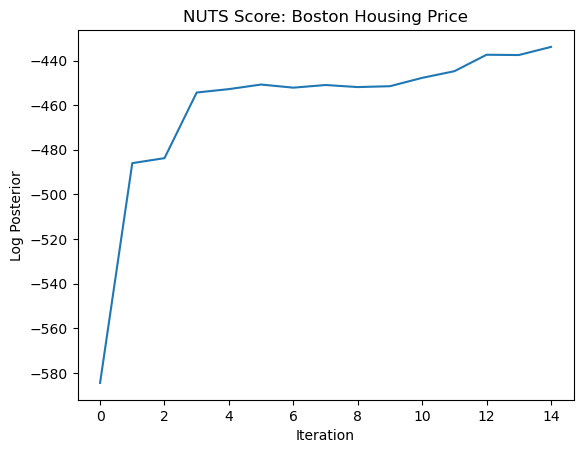

In [30]:
#-----------------------------------
#Plot Log Posterior Scores by Trace
#-----------------------------------

plot([get_score(trace) for trace in traces])
plt.title("NUTS Score: Boston Housing Price")
plt.xlabel("Iteration")
plt.ylabel("Log Posterior");

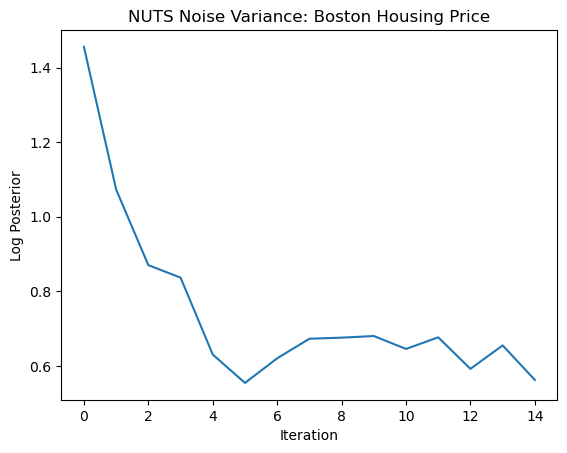

In [31]:
#----------------------------------------
#Plot Regression Noise Variance by Trace
#----------------------------------------

plot([1/trace[:τᵧ] for trace in traces])
plt.title("NUTS Noise Variance: Boston Housing Price")
plt.xlabel("Iteration")
plt.ylabel("Log Posterior");

In [ ]:
#--------------------------------------------
#Plot Parameter Precision by Trace: Function
#--------------------------------------------

function plot_precision(layer)
    weights = []
    biases = []
    for i=1:length(traces)
        trace = traces[i]
        if layer > trace[:l]+1
            push!(weights,NaN)
            push!(biases,NaN)
        else
            push!(weights,trace[(:τ,layer)])
            push!(biases,trace[(:τᵦ,layer)])
        end
    end
    plot(weights,label=("Layer $layer Weights Precision"))
    plot(biases,label="Layer $layer Bias Precision")
    plt.title("NUTS Parameter Precision: Boston Housing Price")
    plt.xlabel("Iteration")
    plt.ylabel("Precision")
    plt.legend();
end

plot_precision(1)
plot_precision(2)

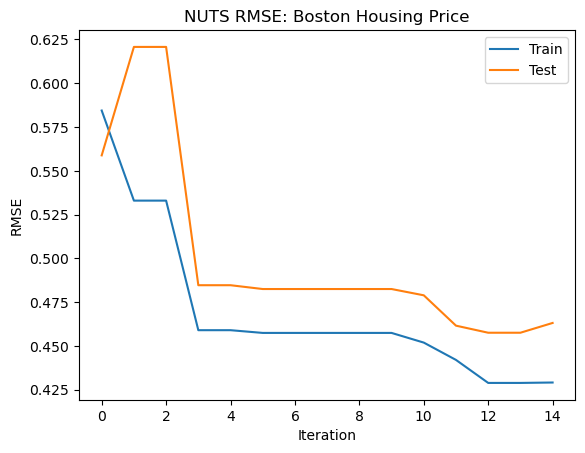

In [32]:
#-------------------------------
#Plot RMSE Train Scores by Trace
#-------------------------------

mses_train = []
for i=1:length(traces)
    trace = traces[i]
    pred_y = transpose(G(x_train,trace))[:,1]
    mse = mse_scaled(pred_y,y_train)

    push!(mses_train,mse)
end

mses_test = []
for i=1:length(traces)
    trace = traces[i]
    pred_y = transpose(G(x_test,trace))[:,1]
    mse = mse_scaled(pred_y,y_test)

    push!(mses_test,mse)
end

plot(mses_train,label="Train")
plot(mses_test, label="Test")
plt.title("NUTS RMSE: Boston Housing Price")
plt.xlabel("Iteration")
plt.ylabel("RMSE");
plt.legend()

best_trace = traces[1]
for i=1:length(traces)
    if get_score(traces[i]) > get_score(best_trace)
        best_trace = traces[i]
    end
end

In [ ]:
#----------------
#Marginalize RMSE
#----------------
j = 5
y_marginal = zeros(length(y_train))

for i=j:length(traces)
    trace = traces[i]
    pred_y = transpose(G(x_train,trace))[:,1]
    y_marginal += (pred_y/(length(traces)-j))
end

#display(y_marginal[1:5])
#display(y[1:5])

mse = mse_scaled(y_marginal, y_train)
println("Training Set Marginal RMSE: $mse")

j = 5
y_marginal = zeros(length(y_test))

for i=j:length(traces)
    trace = traces[i]
    pred_y = transpose(G(x_test,trace))[:,1]
    y_marginal += (pred_y/(length(traces)-j))
end

#display(y_marginal[1:5])
#display(y[1:5])

mse = mse_scaled(y_marginal, y_test)
println("Test Set Marginal RMSE: $mse")

In [ ]:
#HMC Attempt
@gen function gibbs_hyperparameters(trace)
    obs_new = choicemap()::ChoiceMap
    args = get_args(trace)
    argdiffs = map((_) -> NoChange(), args)
    
    for i=1:trace[:l] + 1
        #Biases
        bias = trace[(:b,i)]
        
        n = length(bias)
        α = α₁ + (n/2)
        
        Σ = sum(bias.^2)/2 
        β = 1/(1/β₁ + Σ)
        
        τᵦ ~ gamma(α,β)
        
        #Weights
        i == 1 ? α₀ = α₁ : α₀ = α₂
        i == 1 ? β₀ = β₁ : β₀ = β₂
        
        weight = trace[(:W,i)]
        
        n = length(weight)
        α = α₀ + (n/2)
        
        Σ = sum(weight.^2)/2
        β = 1/(1/β₀ + Σ)
        
        τ ~ gamma(α,β)
        
        obs_new[(:τ,i)] = τ
        obs_new[(:τᵦ,i)] = τᵦ
    end
    
    (new_trace,_,_,_) = update(trace, args, argdiffs, obs_new)
    
    return new_trace
end

@gen function gibbs_noise(trace)
    obs_new = choicemap()::ChoiceMap
    args = get_args(trace)
    argdiffs = map((_) -> NoChange(), args)
    
    n = length(trace[:y])
    α = αᵧ + (n/2)
    
    x = get_args(trace)[1]
    y_pred = transpose(G(x,trace))[:,1]
    y_real = trace[:y]
    Σᵧ = sum((y_pred .- y_real).^2)/2
    β = 1/(1/βᵧ + Σᵧ)
    
    τ ~ gamma(α,β)
    obs_new[:τᵧ] = τ
    
    (new_trace,_,_,_) = update(trace, args, argdiffs, obs_new)
    
    return new_trace
end

l = 1000
ϵ = 0.00079

function within_move(trace)
    l = trace[:l]
    param_selection = select()
    
    for i=1:l+1 #Number of Layers
        push!(param_selection, (:W,i))
        push!(param_selection, (:b,i))
    end
    
    score1 = get_score(trace)
    (new_trace, hmc_score) = hmc_mod(trace, param_selection, L=l, eps=ϵ, check=false, observations=obs)
    
    score2 = get_score(new_trace)
    #println("new trace score: $score2")
    #println("old trace score: $score1")
    
    hmc_score = score2 - score1

    if rand(Uniform(0,1)) < exp(hmc_score)
        trace = new_trace
        accepted = 1.0
        #println("Accepted")
    else
        trace = trace
        accepted = 0.0
        #println("Not Accepted")
    end
    push!(within_acceptance, accepted)

    return trace
end

traces = []
scores = []
across_acceptance = []
within_acceptance = []
trace = best_trace

iters = 1000

for i=1:iters
    #(trace, accepted) = layer_parameter(trace)
    #push!(across_acceptance, accepted)
    trace  = gibbs_hyperparameters(trace)
    trace  = gibbs_noise(trace)
    trace  = within_move(trace)
    push!(scores,get_score(trace))
    push!(traces, trace)
    #println("Iter $i : $(get_score(trace))")
    if i%50 == 0
        #a_acc = 100*(sum(across_acceptance)/length(across_acceptance))
        w_acc = 100*(sum(within_acceptance)/length(within_acceptance))
        #println("Chain $chain Epoch $i A Acceptance Probability: $a_acc %")
        println("Epoch $i W Acceptance Probability: $w_acc %")
    end
    flush(stdout)
end

In [ ]:
trace = traces[1000];

In [ ]:
plot(scores)

In [ ]:
#-------------------------------
#Plot RMSE Train Scores by Trace
#-------------------------------

mses_train = []
for i=1:length(traces)
    trace = traces[i]
    pred_y = transpose(G(x_train,trace))[:,1]
    mse = mse_scaled(pred_y,y_train)

    push!(mses_train,mse)
end

mses_test = []
for i=1:length(traces)
    trace = traces[i]
    pred_y = transpose(G(x_test,trace))[:,1]
    mse = mse_scaled(pred_y,y_test)

    push!(mses_test,mse)
end

plot(mses_train,label="Train")
plot(mses_test, label="Test")
plt.title("NUTS RMSE: Boston Housing Price")
plt.xlabel("Iteration")
plt.ylabel("RMSE");
plt.legend()

best_trace = traces[1]
for i=1:length(traces)
    if get_score(traces[i]) > get_score(best_trace)
        best_trace = traces[i]
    end
end

In [ ]:
taus = [1/traces[i][:τᵧ] for i=1:length(traces)]
plot(taus)

In [ ]:
#----------------
#Marginalize RMSE
#----------------
j = 1
y_marginal = zeros(length(y_train))

for i=j:length(traces)
    trace = traces[i]
    pred_y = transpose(G(x_train,trace))[:,1]
    y_marginal += (pred_y/(length(traces)-j))
end

#display(y_marginal[1:5])
#display(y[1:5])

mse = mse_scaled(y_marginal, y_train)
println("Training Set Marginal RMSE: $mse")

j = 1
y_marginal = zeros(length(y_test))

for i=j:length(traces)
    trace = traces[i]
    pred_y = transpose(G(x_test,trace))[:,1]
    y_marginal += (pred_y/(length(traces)-j))
end

#display(y_marginal[1:5])
#display(y[1:5])

mse = mse_scaled(y_marginal, y_test)
println("Test Set Marginal RMSE: $mse")